### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [3]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [2]:
import numpy as np
import math 
HW3_Data=np.load('/home/hoelsczj/repos/astr_8070_S24/coursework/homeworks/hw_data/hw3_data_1.npy')
#print("Measurements:    Uncertainties:")
#print(HW3_Data)

Question I: 

Results from Lecture V:
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [3]:
Sum1=0
Sum2=0 #Initializing sums to zero 
for row in HW3_Data: #Pulling each row in the table, which is itself a two-element array 
    xi=row[0] #data point is the first value 
    sigmai=row[1] #Uncertainty is the second value 
    Sum1=Sum1+(xi/(sigmai**2)) #The numerator of the first expression written above 
    Sum2=Sum2+(1/(sigmai**2)) #The denominator of the first expression written above 
mu=Sum1/Sum2 
sigmamu=1/math.sqrt(Sum2) 
print("Sample Mean: ")
print(mu)
print("Standard Error: ")
print(sigmamu)


Sample Mean: 
3.917992034606058
Standard Error: 
0.09481084100510956


Question II:

From Lecture VIII:
$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

In [4]:
import scipy 
def NegLnLikelihood(mu_variable):
    LogLikelihood=0
    for row in HW3_Data:
        xi=row[0] #data point is the first value 
        sigmai=row[1] #Uncertainty is the second value 
        LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))
        #I applied the fact that the Log of a product is the sum of the logs of the terms. 
    return -1*LogLikelihood #Multiply by negative 1 so the minimizer will maximize the log likelihood. 
Output=scipy.optimize.minimize(NegLnLikelihood, 4) #Find extremum with initial guess of 4.
print(Output)
print("Best fit mean: ")
print(Output.x)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 147.2578628873088
        x: [ 3.918e+00]
      nit: 1
      jac: [-3.815e-06]
 hess_inv: [[1]]
     nfev: 6
     njev: 3
Best fit mean: 
[3.91799205]


/tmp/ipykernel_45217/1784518230.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))


Question III:

The process in Lecture V is applied to a homoscedastic Gaussian, though the assignment says to follow the same process followed in that lecture, so I am following that method. 

In [5]:
xgrid=np.linspace(3,5,10000) #Create array of 10000 points between 3 and 5. 
LogLikelihoodList=[] #Initialize as empty list 
for mu_variable in xgrid: #Calculate log likelihood for each value in the xgrid array. 
    LogLikelihood=0
    for row in HW3_Data:
        xi=row[0] #data point is the first value 
        sigmai=row[1] #Uncertainty is the second value 
        LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))
        #I applied the fact that the Log of a product is the sum of the logs of the terms. 
    LogLikelihoodList.append(LogLikelihood)
sigma_mu = -1*np.diff(LogLikelihoodList, n=2)/(xgrid[1]-xgrid[0])**2 #Calculate second derivative, multiply by -1
sigma_mu = 1/np.sqrt(sigma_mu)[0] 

print("Fisher matrix error on estimated mean is: ")
print(sigma_mu)

Fisher matrix error on estimated mean is: 
0.09481084008129899


Question IV:

In [6]:
import random
xiList=[]
SigmaiList=[] #Initializing empty lists. I'll load all xi and sigmai values into these. 
for row in HW3_Data: #Pulling each row in the table, which is itself a two-element array 
    xi=row[0] #data point is the first value 
    xiList.append(xi)
    sigmai=row[1] #Uncertainty is the second value 
    SigmaiList.append(sigmai)
Bootstrap_All_Samples=[] #Initialize empty list. Each element will be a boostrap sample. (1000 of these.)
Number_Samples_Done=0 #Start at zero 
while Number_Samples_Done<1000: #Keep going until 1000 done 
    BootstrapSample=[] #Clear this to empty list. Will hold pairs of xi and sigmai values. 
    for element in xiList: #Randomly sample elements as many times as there are elements in xi
        index=random.randint(0,len(xiList)-1) #Use random number generator to randomly pick values 
        BootstrapSample.append([xiList[index],SigmaiList[index]]) #Keeps xi and sigmai values together 
    Bootstrap_All_Samples.append(BootstrapSample)
    Number_Samples_Done=Number_Samples_Done+1

Question V:

/tmp/ipykernel_45217/2470746335.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))
/tmp/ipykernel_45217/2470746335.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))
/tmp/ipykernel_45217/2470746335.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (De

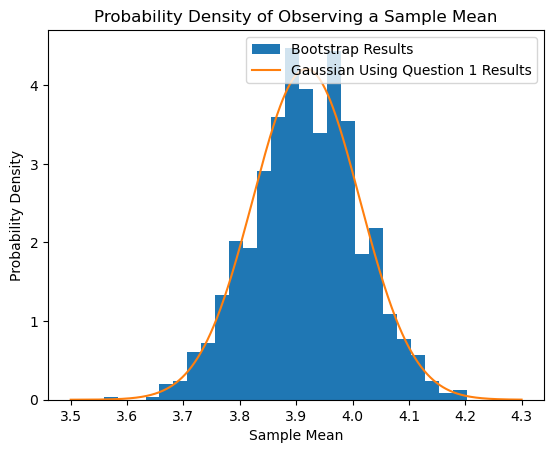

In [7]:
from matplotlib import pyplot as plt 
MuList=[]
i=0
while i<1000: #Do this 1000 times
    BootstrapSample=Bootstrap_All_Samples[i]
    def NegLnLikelihood(mu_variable): #Defining this inside of a while loop is poor form but it works and is really easy to write 
        LogLikelihood=0
        for row in BootstrapSample:
            xi=row[0] #data point is the first value 
            sigmai=row[1] #Uncertainty is the second value 
            LogLikelihood=LogLikelihood+math.log(math.exp((-(xi-mu_variable)**2)/(2*sigmai*sigmai))/(sigmai*math.sqrt(2*math.pi)))
            #I applied the fact that the Log of a product is the sum of the logs of the terms. 
        return -1*LogLikelihood #Multiply by negative 1 so the minimizer will maximize the log likelihood. 
    Output=scipy.optimize.minimize(NegLnLikelihood, 4) #Find extremum with initial guess of 4.
    MuList.append(Output.x[0]) #Append fitted value of Mu to the list
    i=i+1
plt.hist(MuList, bins='auto', density=True, label="Bootstrap Results") #Histogram, normalized 
mu_Question_1=3.917992034606058
Std_Error_Question_1=0.09481084100510956 #Values from question 1. Renaming them so it is clear where they are from. 
xgrid=np.linspace(3.5,4.3,1000) #Create array of 1000 points 
plt.plot(xgrid, scipy.stats.norm.pdf(xgrid, mu_Question_1, Std_Error_Question_1), label="Gaussian Using Question 1 Results") #Plot Gaussian
plt.legend(loc="upper right")
plt.xlabel("Sample Mean")
plt.ylabel("Probability Density")
plt.title("Probability Density of Observing a Sample Mean")
plt.show()

Yes, the Gaussian corresponding to the values from Question 1 does roughly match the histogram. This suggests things are working well. 

Question VI:

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 156.78891617659045
       x: [ 8.823e-01  4.084e+00]
     nit: 7
     jac: [ 8.527e-06  0.000e+00]
    nfev: 69
Best fit parameter values: 
Delta: 
0.8822693039865328
Mu: 
4.083910855391068


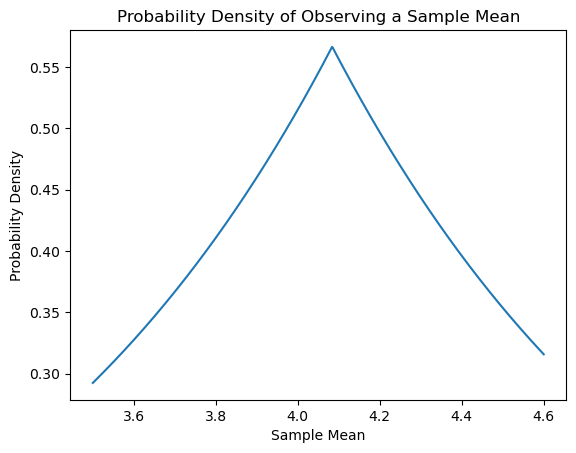

In [20]:
def Neg_LnLikelihood_Laplacian(parameters):
    Delta=parameters[0]
    mu=parameters[1]
    LnLikelihood=0
    for row in HW3_Data:
        xi=row[0] #data point is the first value 
        sigmai=row[1] #Uncertainty is the second value 
        p=(1/(2*Delta))*math.exp(-1*math.fabs(xi-mu)/Delta)
        LnLikelihood=LnLikelihood+math.log(p)
        #I applied the fact that the Log of a product is the sum of the logs of the terms. 
    return -1*LnLikelihood #Multiply by negative 1 so the minimizer will maximize the log likelihood. 
constraints = ((0.1, 90), (0.1, 90)) #Restrict parameter values to be positive and not absurdly large 
Output=scipy.optimize.minimize(Neg_LnLikelihood_Laplacian, x0=[4,4], method='TNC', bounds=constraints) #Find extremum with initial guess of 4.
print(Output)
Delta=Output.x[0]
Mu=Output.x[1]
print("Best fit parameter values: ")
print("Delta: ")
print(Delta)
print("Mu: ")
print(Mu)
    
plt.clf() #Clear figure 
xgrid=np.linspace(3.5,4.6,1000) #Create array of 1000 points 

Distribution = scipy.stats.laplace(Mu, Delta)
pdf = Distribution.pdf(xgrid)
plt.plot(xgrid, pdf) #Plot Laplacian distribution to check fit
plt.xlabel("Sample Mean")
plt.ylabel("Probability Density")
plt.title("Probability Density of Observing a Sample Mean")
plt.show()

Question VII:

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

$k$ : the number of model parameters 

$N$ : the number of data points

In [9]:
Gaussian_Log_Likelihood=-147.2578628873088
k_Gaussian=1
N=100
AIC_Gaussian=-2*Gaussian_Log_Likelihood+2*k_Gaussian+(2*k_Gaussian*(k_Gaussian+1)/(N-k_Gaussian-1))

Laplacian_Log_Likelihood=-156.78891617659045
k_Laplacian=2
N=100
AIC_Laplacian=-2*Laplacian_Log_Likelihood+2*k_Laplacian+(2*k_Laplacian*(k_Laplacian+1)/(N-k_Laplacian-1))

print("AIC for Gaussian: ")
print(AIC_Gaussian)

print("AIC for Laplacian: ")
print(AIC_Laplacian)


AIC for Gaussian: 
296.5565421011482
AIC for Laplacian: 
317.70154369338707


The Gaussian model has a lower value for the AIC, so it is favored over the Laplacian model. 

Question VIII:

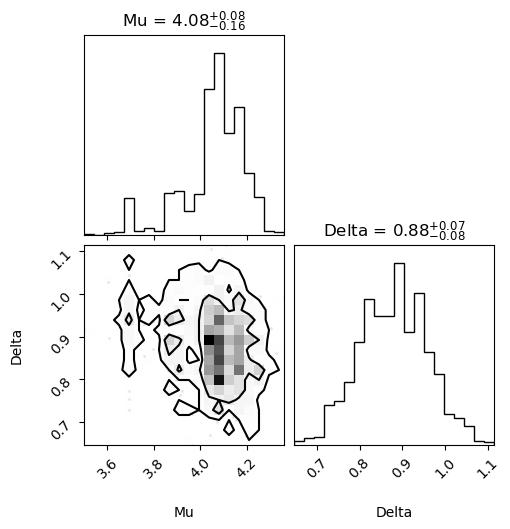

In [10]:
from matplotlib import pyplot as plt 
Delta_Laplacian_List=[]
Mu_Laplacian_List=[]
i=0
while i<1000: #Do this 1000 times
    BootstrapSample=Bootstrap_All_Samples[i]
    def Neg_LnLikelihood_Laplacian(parameters):
        Delta=parameters[0]
        mu=parameters[1]
        LnLikelihood=0
        for row in BootstrapSample:
            xi=row[0] #data point is the first value 
            sigmai=row[1] #Uncertainty is the second value 
            p=(1/(2*Delta))*math.exp(-1*math.fabs(xi-mu)/Delta)
            LnLikelihood=LnLikelihood+math.log(p)
            #I applied the fact that the Log of a product is the sum of the logs of the terms. 
        return -1*LnLikelihood #Multiply by negative 1 so the minimizer will maximize the log likelihood. 
    constraints = ((0.1, 90), (0.1, 90)) #Restrict parameter values to be positive and not absurdly large 
    Output=scipy.optimize.minimize(Neg_LnLikelihood_Laplacian, x0=[4,4], method='TNC', bounds=constraints) #Find extremum with initial guess of 4.
    Delta_Laplacian=Output.x[0]
    Mu_Laplacian=Output.x[1]
    Delta_Laplacian_List.append(Delta_Laplacian)
    Mu_Laplacian_List.append(Mu_Laplacian)
    i=i+1

#This makes histograms. Not needed, so commented out. 
"""
plt.clf()
plt.title("Mu Probability Density")
plt.hist(Mu_Laplacian_List, bins=15, density=True) #Histogram, normalized 
plt.show()
plt.clf()
plt.title("Delta Probability Density")
plt.hist(Delta_Laplacian_List, bins='auto', density=True)
plt.show()
plt.clf()
"""

import corner #Making corner plots here 
Corner_Plot_Data=[] #Initialize empty list 
for index in range(0,len(Mu_Laplacian_List)): #Fill values for fitted Mu and Delta 
    Corner_Plot_Data.append([Mu_Laplacian_List[index], Delta_Laplacian_List[index]])
Corner_Plot_Data=np.array(Corner_Plot_Data) #Convert list to array 

#Make the corner plot with labels and titles, 68% and 95% for levels 
fig = corner.corner(Corner_Plot_Data, levels=(0.68,0.95), labels=["Mu", "Delta"], show_titles=True)




Question IX:


In [28]:
import numdifftools as nd
xgrid=np.linspace(3.5,4.6,1000) #Create array of 1000 points 
Delta=0.8822693039865328
mu=4.0839108553910684

def LnLikelihood_Laplacian(Delta, mu):
    LnLikelihood=0
    for row in HW3_Data:
        xi=row[0] #data point is the first value 
        p=(1/(2*Delta))*math.exp(-1*math.fabs(xi-mu)/Delta)
        LnLikelihood=LnLikelihood+math.log(p)
        #I applied the fact that the Log of a product is the sum of the logs of the terms. 
    return LnLikelihood 

H = nd.Hessian(LnLikelihood_Laplacian)(Delta, mu)
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace)


/tmp/ipykernel_45217/3531745399.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p=(1/(2*Delta))*math.exp(-1*math.fabs(xi-mu)/Delta)
/tmp/ipykernel_45217/3531745399.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LnLikelihood=LnLikelihood+math.log(p)


ValueError: math domain error

I don't understand why it is throwing the math domain error. From playing with it, it seems to be changing the value of Delta when it is not supposed to. I thus cannot compare the results to the previous plots. 